# <span style="color:blue">Desafío 5- Prediciendo los precios de las casas</span>

## <span style="color:orange">Importación de librerías - Cargar la data</span>

In [317]:
# Suprimir advertencias para una salida más limpia
import warnings
warnings.filterwarnings('ignore')

# Librerías esenciales para análisis de datos y visualización
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Herramientas de Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor

# Cargar los datos 
house_data = pd.read_excel(r"C:\Users\atapi\Documents\DATA SCIENCE\Modulo 5-ML\aprendizaje no supervisado IV\desafío\Apoyo Desafío - Prediciendo los precios de las casas\house_data.xlsx")

# Mostrar las primeras filas del dataset para exploración inicial
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [318]:
# Información general del dataset
house_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  int64  
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

## <span style="color:orange">Limpieza y Exploración de datos</span>

**Con la infomación inicial del dataset podemos comenzar con la limpieza y exploración de los datos**

- **Pasos a seguir:**
  
    - **Eliminar columnas irrelevantes:** La columna id probablemente no aporte valor al análisis de regresión, ya que es un identificador único.
    - **Verificar datos duplicados:** Aunque no parece haber duplicados en las primeras filas, se realizará un análisis más amplio.
    - **Análisis de valores faltantes:** Según la información no hay valores faltantes en ninguna columna.
    - **Identificar y manejar datos atípicos:** Revisar columnas clave como *price*, *bedrooms*, *bathrooms* y *sqft_living* para detectar valores extremos.
    - **Preparación final:** Convertir la columna *date* a formato de fecha, esto es porque puede ser útil para análisis adicionales.

In [320]:
# Limpieza y preparación inicial de los datos
# Eliminar la columna 'id', ya que no es relevante para el análisis
data_limpia = house_data.drop(columns=['id'])

# Convertir la columna 'date' al formato de fecha
data_limpia['date'] = pd.to_datetime(data_limpia['date'], format='%Y%m%dT%H%M%S', errors='coerce')

# Verificar valores faltantes después de la conversión
valores_faltantes = data_limpia.isnull().sum()

# Revisar duplicados
conteo_duplicados = data_limpia.duplicated().sum()
if conteo_duplicados > 0:
    data_limpia = data_limpia.drop_duplicates()

# Análisis de outliers: Obtener resumen estadístico general
resumen_outlier = data_limpia.describe()

# Revisar los cambios realizados y mostrar un resumen
resumen_limpieza = {
    "Duplicados eliminados": conteo_duplicados,
    "Valores faltantes": valores_faltantes.to_dict(),
    "Columnas eliminadas": ["id"],
    "Transformaciones": ["date convertida a formato datetime"]
}

# Imprimir resumen estadístico
print("Resumen estadístico del DataFrame con outliers:\n")
resumen_outlier



Resumen estadístico del DataFrame con outliers:



,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,2014-10-29 04:38:01.959931648,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
min,2014-05-02 00:00:00,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2014-07-22 00:00:00,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,2014-10-16 00:00:00,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,2015-02-17 00:00:00,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,2015-05-27 00:00:00,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000
std,NaN,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631


In [321]:
# Imprimir resumen de la limpieza
print("\nResumen de limpieza:\n")
for key, value in resumen_limpieza.items():
    print(f"{key}: {value}")



Resumen de limpieza:

Duplicados eliminados: 0
Valores faltantes: {'date': 0, 'price': 0, 'bedrooms': 0, 'bathrooms': 0, 'sqft_living': 0, 'sqft_lot': 0, 'floors': 0, 'waterfront': 0, 'view': 0, 'condition': 0, 'grade': 0, 'sqft_above': 0, 'sqft_basement': 0, 'yr_built': 0, 'yr_renovated': 0, 'zipcode': 0, 'lat': 0, 'long': 0, 'sqft_living15': 0, 'sqft_lot15': 0}
Columnas eliminadas: ['id']
Transformaciones: ['date convertida a formato datetime']


**Manejo de Outliers**

En algunos casos, los outliers pueden contener información relevante para el modelo, como en el caso del precio de las casas. Sin embargo, si el cliente decide que los valores atípicos deben manejarse, se puede aplicar el método del Rango Intercuartílico (IQR).

- **Consideraciones para incluir el manejo de outliers:**
  - Los outliers extremos pueden distorsionar modelos sensibles, como la regresión lineal.
  - Su manejo puede mejorar la estabilidad de las métricas de evaluación.

- **Consideraciones para no manejar outliers:**
  - Si los outliers son datos válidos no errores, eliminarlos podría reducir la capacidad del modelo para generalizar.
  - Métodos como los árboles de decisión son robustos frente a outliers y pueden manejarlos adecuadamente.

En la etapa de exploración de los datos, los outliers pueden identificarse mediante boxplots o resúmenes estadísticos. 

**Decisión basada en el cliente:**
Este código incluye una función para manejar outliers con IQR, que puede activarse o desactivarse según los requerimientos específicos del cliente.


In [323]:
# Detectar y manejar outliers con IQR
def manejar_outliers_iqr(df, columnas):
    for columna in columnas:
        Q1 = df[columna].quantile(0.25)  # Primer cuartil
        Q3 = df[columna].quantile(0.75)  # Tercer cuartil
        IQR = Q3 - Q1  # Rango intercuartílico

        # Definir límites superior e inferior
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Filtrar los datos dentro del rango permitido
        df = df[(df[columna] >= limite_inferior) & (df[columna] <= limite_superior)]
    
    return df

# Seleccionar columnas numéricas relevantes para aplicar IQR
columnas_revisar = ['price', 'bedrooms', 'bathrooms', 'sqft_living']

# Aplicar IQR para manejar outliers
data_limpia = manejar_outliers_iqr(data_limpia, columnas_revisar)

# Resumen estadístico después de eliminar outliers
resumen_post_outliers = data_limpia.describe()

print("\nResumen estadístico después de manejar outliers:\n")
resumen_post_outliers



Resumen estadístico después de manejar outliers:



,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,19649,1.964900e+04,19649.000000,19649.000000,19649.000000,1.964900e+04,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000
mean,2014-10-29 09:16:49.700239104,4.706188e+05,3.296911,2.025637,1933.164792,1.391791e+04,1.470915,0.002748,0.164080,3.411166,7.508525,1676.914703,256.250089,1970.845845,72.108402,98078.578452,47.556311,-122.214244,1903.313604,12013.519467
min,2014-05-02 00:00:00,7.800000e+04,2.000000,0.500000,440.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,4.000000,440.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2014-07-22 00:00:00,3.150000e+05,3.000000,1.500000,1400.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1170.000000,0.000000,1952.000000,0.000000,98033.000000,47.457800,-122.330000,1470.000000,5036.000000
50%,2014-10-16 00:00:00,4.349000e+05,3.000000,2.000000,1840.000000,7.485000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1509.000000,0.000000,1974.000000,0.000000,98065.000000,47.566600,-122.233000,1790.000000,7506.000000
75%,2015-02-18 00:00:00,5.930000e+05,4.000000,2.500000,2390.000000,1.019000e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2060.000000,500.000000,1996.000000,0.000000,98118.000000,47.680000,-122.124000,2250.000000,9792.000000
max,2015-05-24 00:00:00,1.127000e+06,5.000000,4.000000,3950.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,11.000000,3950.000000,1990.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,4950.000000,560617.000000
std,NaN,2.021294e+05,0.782150,0.669018,698.821116,3.773046e+04,0.537296,0.052353,0.623451,0.647407,0.991280,673.670575,391.078919,29.026657,372.443974,53.415973,0.141512,0.141643,587.410643,24819.086963


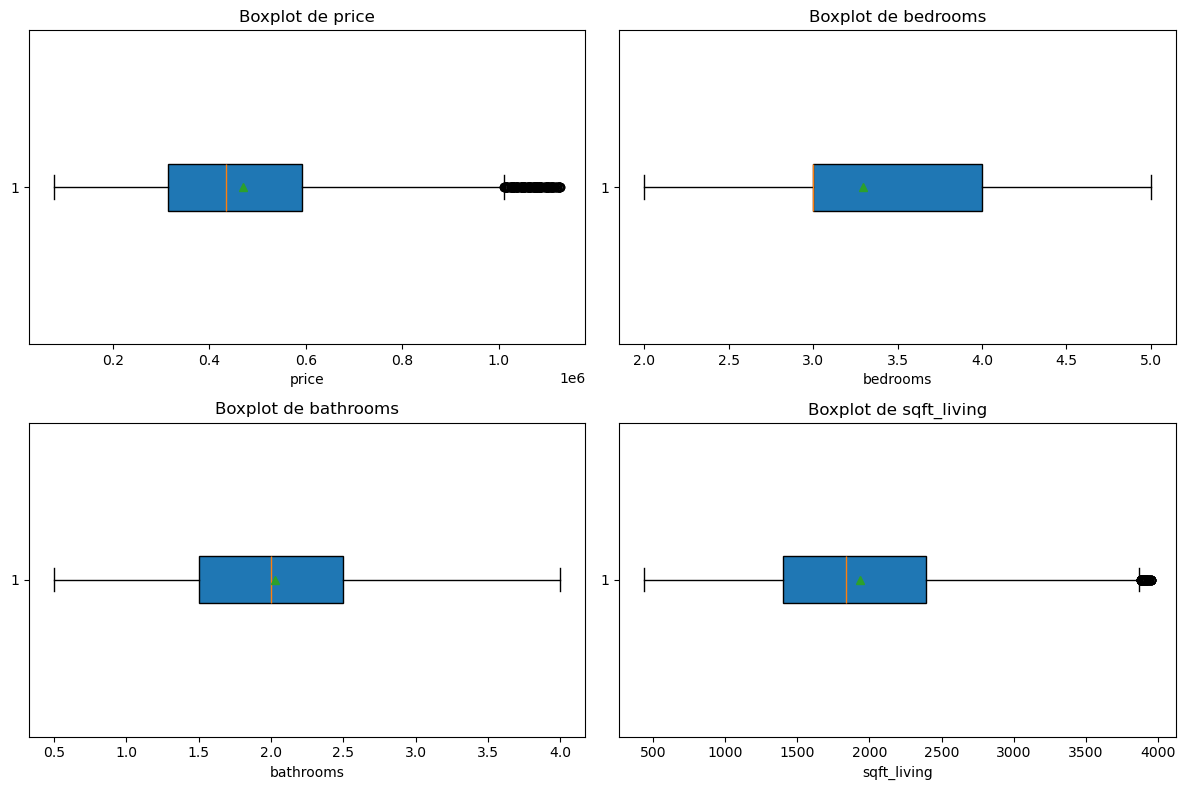

In [324]:
# Crear boxplots para las columnas antes de aplicar el manejo de outliers
columnas_revisar = ['price', 'bedrooms', 'bathrooms', 'sqft_living']

# Configurar subgráficos para mostrar los boxplots
plt.figure(figsize=(12, 8))
for i, columna in enumerate(columnas_revisar, 1):
    plt.subplot(2, 2, i)
    plt.boxplot(data_limpia[columna], vert=False, patch_artist=True, showmeans=True)
    plt.title(f'Boxplot de {columna}')
    plt.xlabel(columna)

plt.tight_layout()
plt.show()


- **Columnas seleccionadas:** Se analizaron las variables clave: price (precio), bedrooms (número de dormitorios), bathrooms (número de baños), y sqft_living (metros cuadrados habitables).
- **Análisis por columna:**
    - **price (precio):** Se observan puntos fuera de los límites superiores del boxplot, lo que indica la presencia de outliers en esta variable.
Estos puntos podrían corresponder a propiedades de lujo o excepcionales con precios significativamente mayores al promedio.

    - **bedrooms (dormitorios) y bathrooms (baños),:** No se observan puntos fuera de los límites, lo que indica que no hay outliers detectados en estas variables.
 
    -  **sqft_living (metros cuadrados habitables):** Se detectan algunos puntos fuera de los límites superiores del boxplot, lo que sugiere la existencia de outliers. Estos valores probablemente representan propiedades con áreas habitables excepcionalmente grandes.

- **Conclusión:** Los outliers más destacados se encuentran en las *variables price* y *sqft_living*.
Para la variable price, es importante considerar si estos outliers deben incluirse o eliminarse en función de los objetivos del análisis:
    - Si se desea modelar precios incluyendo propiedades de lujo, los outliers no deberían ser eliminados.
    - Si el enfoque es en propiedades con precios más estándar, se recomienda aplicar la eliminación de outliers utilizando la función IQR.

En las variables bedrooms y bathrooms no se detectan outliers, por lo que no requieren tratamiento adicional.

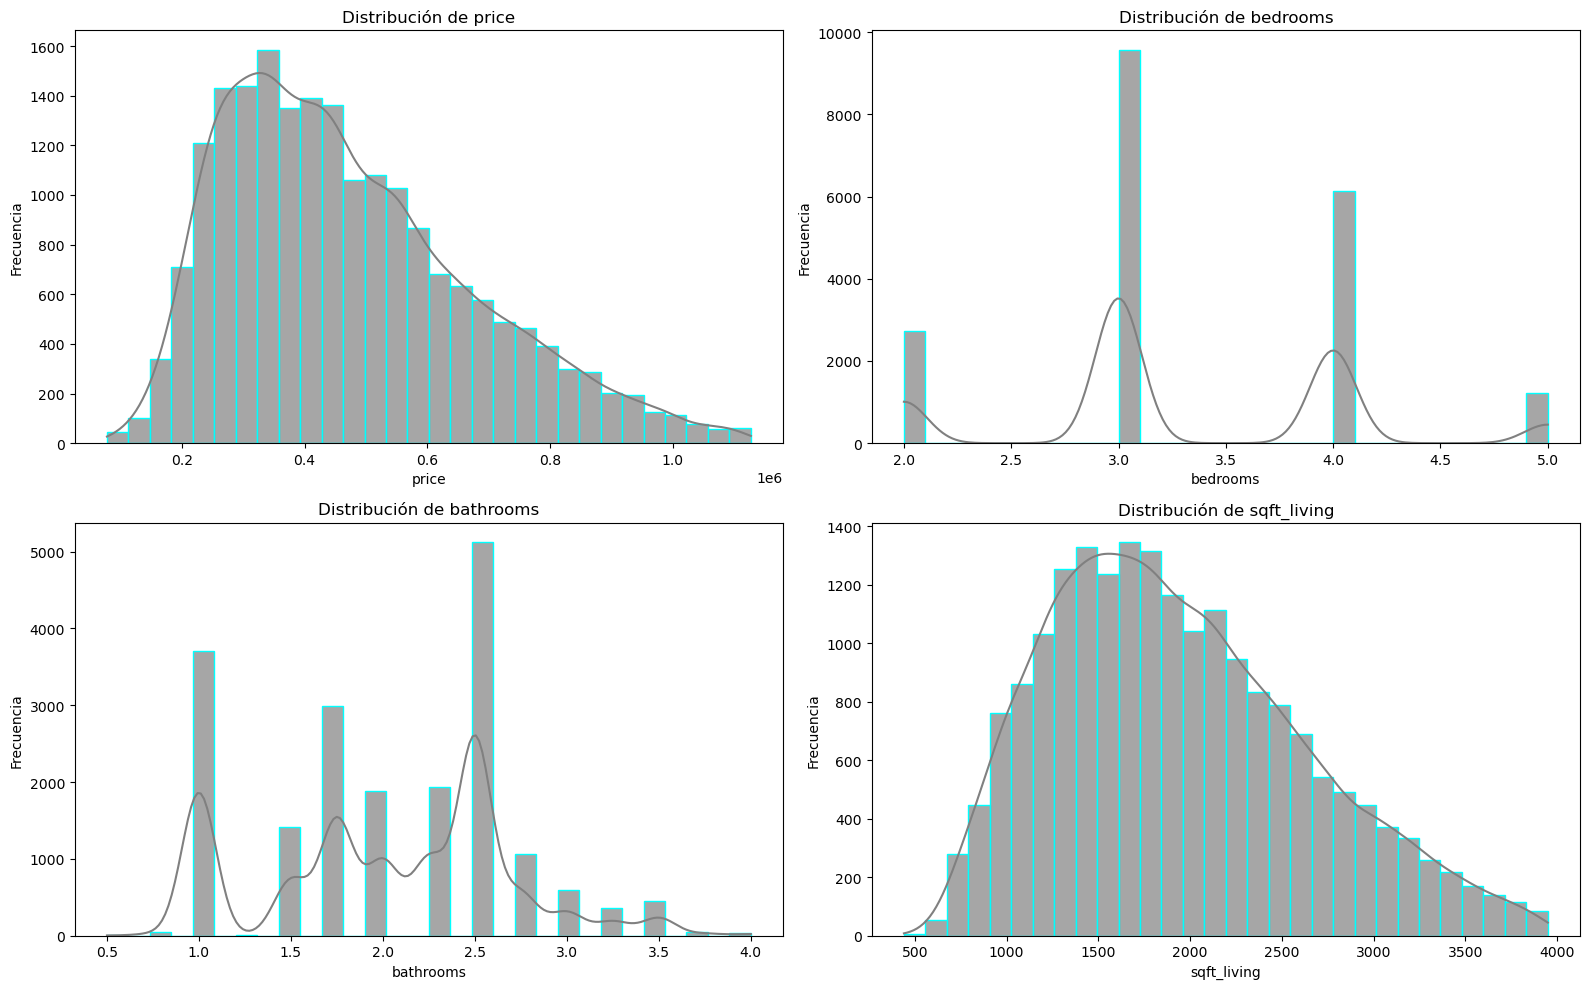

In [326]:
# Visualización de la distribución de los datos para las columnas numéricas
# Seleccionar columnas numéricas relevantes
columnas_numericas = ['price', 'bedrooms', 'bathrooms', 'sqft_living']

# Configurar gráficos para mostrar histogramas y gráficos de densidad
plt.figure(figsize=(16, 10))
for i, columna in enumerate(columnas_numericas, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data_limpia[columna], kde=True, bins=30, color='grey', edgecolor='cyan', alpha=0.7)
    plt.title(f'Distribución de {columna}')
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


**<span style="color:purple">Análisis de la Distribución de las Variables</span>**

1. **price (Precio de las casas)**
- La distribución de los precios es asimétrica hacia la derecha (sesgo positivo).
- La mayoría de las casas tienen precios entre **200,000 y 600,000**, pero hay valores extremos que representan propiedades de mayor valor.
- Este sesgo positivo es típico en datasets de bienes raíces, ya que las propiedades de lujo suelen ser menos frecuentes.

2. **bedrooms (Cantidad de dormitorios)**
- La distribución es discreta, con picos en valores comunes como **3 y 4 dormitorios**, lo cual indica que estas son configuraciones típicas.
- Hay poca variabilidad en el número de dormitorios, lo que sugiere que la mayoría de las propiedades tienen un diseño estándar.
- No se observan valores extremos significativos en esta variable.

3. **bathrooms (Cantidad de baños)**
- La distribución es irregular pero con un sesgo hacia **2 baños**, que parece ser el valor más frecuente.
- Existen casas con un mayor número de baños (hasta 3.5), lo que puede indicar propiedades más grandes o lujosas.
- Aunque no hay valores extremos significativos, las propiedades con muchos baños podrían ser menos representativas.

4. **sqft_living (Metros cuadrados habitables)**
- La distribución es ligeramente asimétrica hacia la derecha, con la mayoría de las casas entre **1,000 y 2,500 pies cuadrados**.
- Existen algunas propiedades con un área habitable significativamente mayor.
- Este patrón refleja la diversidad de tamaños de las viviendas, desde casas pequeñas hasta propiedades más amplias.

**Conclusión**
- Las variables **price** y **qft_living** presentan cierta asimetría hacia la derecha, lo cual podría influir en los modelos de regresión.
- Las variables **bedrooms** y **bathrooms** tienen distribuciones discretas y concentradas en valores comunes, reflejando configuraciones estándar en las propiedades.
- Si bien los outliers en **price** son evidentes, podrían ser datos válidos y útiles para modelar precios altos.


## <span style="color:orange">Análisis descriptivo y exploratorio de las variables</span>

En este punto se realiza un análisis exploratorio de los datos para entender las características principales del dataset y detectar posibles relaciones entre las variables predictoras y el precio de las casas. A continuación se describen los pasos llevados a cabo:

1. **Estadísticas descriptivas:** Se genera un resumen estadístico de las variables numéricas del dataset utilizando la función *describe()*. Este análisis nos permite identificar tendencias generales, valores mínimos y máximos, así como medidas de dispersión como la desviación estándar.

2. **Visualización de relaciones con el precio:** Para entender cómo se relacionan las características clave con el precio (*price*), se crean gráficos de dispersión (*scatterplots*) que muestran la interacción entre:
- *sqft_living*: Tamaño habitable en pies cuadrados.
- *bedrooms*: Número de habitaciones.
- *bathrooms*: Número de baños.
- *sqft_lot*: Tamaño del terreno en pies cuadrados.

Estos gráficos permiten observar patrones o tendencias lineales y no lineales entre las características y el precio.

3. **Análisis de correlaciones generales:** Se calcula una matriz de correlaciones para todas las variables numéricas del dataset. De esta matriz, se extraen las correlaciones específicas del precio con las demás características, las cuales se ordenan para identificar las relaciones más fuertes. Estas correlaciones se visualizan mediante un mapa de calor (*heatmap*), que permite destacar las relaciones positivas y negativas.

4. **Análisis de correlaciones específicas:** Además de la matriz general, se seleccionan únicamente las variables relacionadas con el precio (*sqft_living*, *bedrooms*, *bathrooms*, *sqft_lot*) para generar un mapa de calor más enfocado. Esto ayuda a explorar cómo estas características específicas influyen en el precio y facilita una interpretación más precisa.


**Este análisis nos permite:**
1. Identificar las variables más relevantes para predecir el precio.
2. Detectar patrones y tendencias que guiarán los pasos posteriores del modelado.
3. Preparar la información necesaria para justificar decisiones relacionadas con la selección de variables predictoras.

**Nota:** Los gráficos generados proporcionan una visión clara de cómo cada característica afecta al precio y qué tan fuertes son estas relaciones, lo cual es esencial para el desarrollo de modelos predictivos más precisos.


In [329]:
# Estadísticas descriptivas
print("Estadísticas descriptivas generales:\n")
data_limpia.describe()


Estadísticas descriptivas generales:



,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,19649,1.964900e+04,19649.000000,19649.000000,19649.000000,1.964900e+04,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000,19649.000000
mean,2014-10-29 09:16:49.700239104,4.706188e+05,3.296911,2.025637,1933.164792,1.391791e+04,1.470915,0.002748,0.164080,3.411166,7.508525,1676.914703,256.250089,1970.845845,72.108402,98078.578452,47.556311,-122.214244,1903.313604,12013.519467
min,2014-05-02 00:00:00,7.800000e+04,2.000000,0.500000,440.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,4.000000,440.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2014-07-22 00:00:00,3.150000e+05,3.000000,1.500000,1400.000000,5.000000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1170.000000,0.000000,1952.000000,0.000000,98033.000000,47.457800,-122.330000,1470.000000,5036.000000
50%,2014-10-16 00:00:00,4.349000e+05,3.000000,2.000000,1840.000000,7.485000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1509.000000,0.000000,1974.000000,0.000000,98065.000000,47.566600,-122.233000,1790.000000,7506.000000
75%,2015-02-18 00:00:00,5.930000e+05,4.000000,2.500000,2390.000000,1.019000e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2060.000000,500.000000,1996.000000,0.000000,98118.000000,47.680000,-122.124000,2250.000000,9792.000000
max,2015-05-24 00:00:00,1.127000e+06,5.000000,4.000000,3950.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,11.000000,3950.000000,1990.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,4950.000000,560617.000000
std,NaN,2.021294e+05,0.782150,0.669018,698.821116,3.773046e+04,0.537296,0.052353,0.623451,0.647407,0.991280,673.670575,391.078919,29.026657,372.443974,53.415973,0.141512,0.141643,587.410643,24819.086963


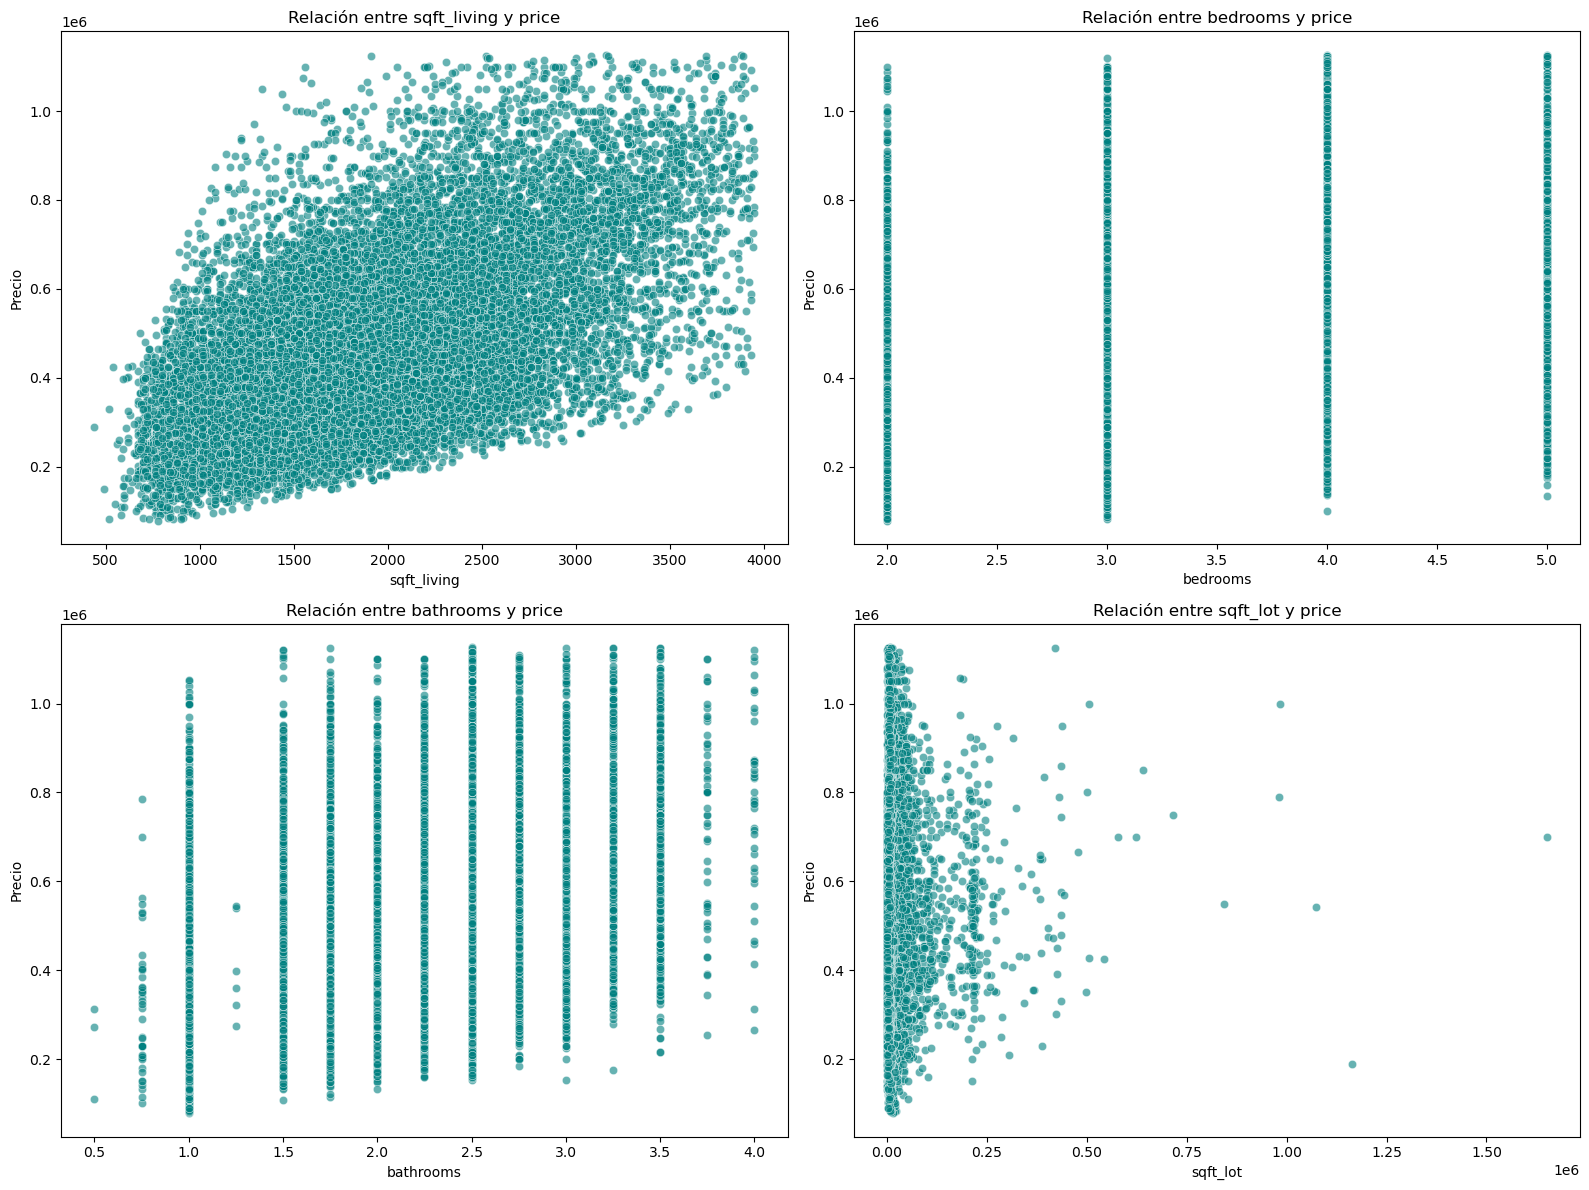

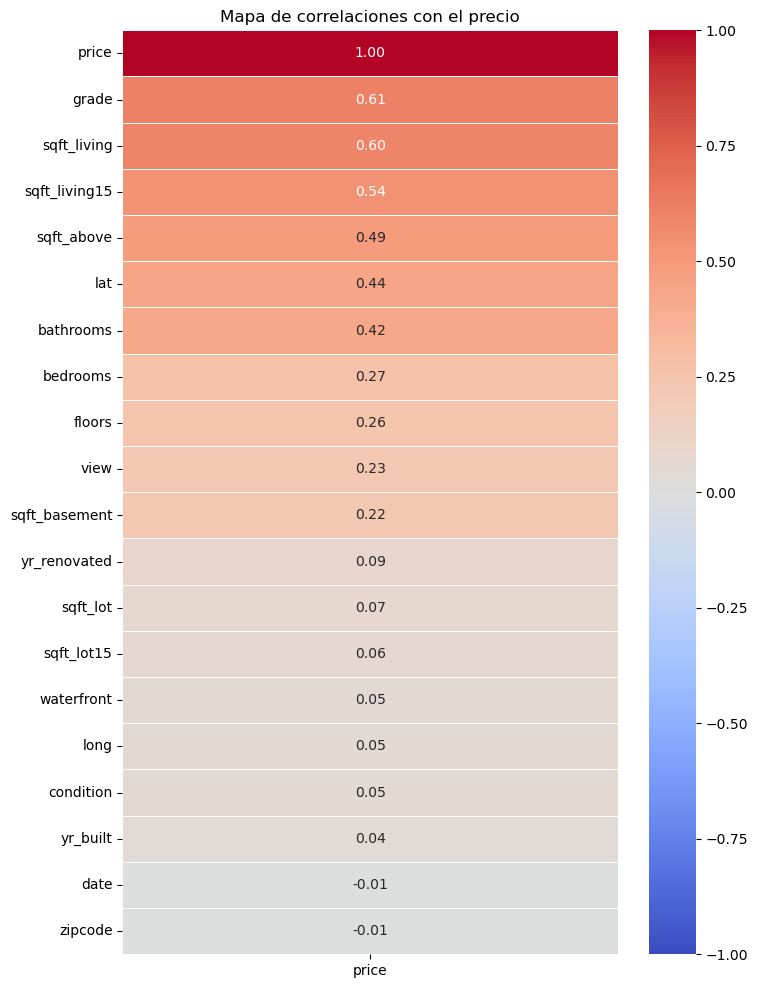

In [330]:
# Visualización de relaciones entre las características y el precio
columnas_relacionadas = ['sqft_living', 'bedrooms', 'bathrooms', 'sqft_lot']

# Configurar subgráficos para scatterplots
plt.figure(figsize=(16, 12))
for i, columna in enumerate(columnas_relacionadas, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(data=data_limpia, x=columna, y='price', color='teal', alpha=0.6)
    plt.title(f'Relación entre {columna} y price')
    plt.xlabel(columna)
    plt.ylabel('Precio')

plt.tight_layout()
plt.show()

# Cálculo de correlaciones entre las variables numéricas
correlaciones = data_limpia.corr()

# Filtrar solo las correlaciones con el precio
correlaciones_price = correlaciones[['price']].sort_values(by='price', ascending=False)

# Visualización de las correlaciones con el precio
plt.figure(figsize=(8, 12))
sns.heatmap(correlaciones_price, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Mapa de correlaciones con el precio')
plt.show()


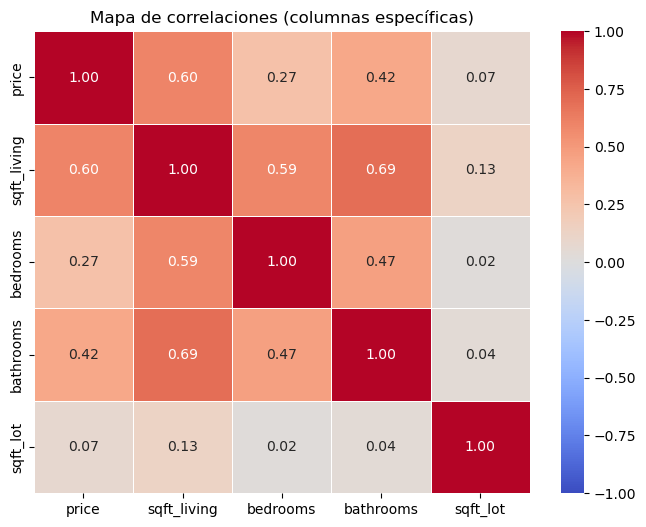

In [331]:
# Seleccionar columnas específicas más el precio
columnas_relacionadas = ['price', 'sqft_living', 'bedrooms', 'bathrooms', 'sqft_lot']

# Calcular correlaciones para las columnas seleccionadas
correlaciones_especificas = data_limpia[columnas_relacionadas].corr()

# Visualización del mapa de calor para las columnas seleccionadas
plt.figure(figsize=(8, 6))
sns.heatmap(correlaciones_especificas, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Mapa de correlaciones (columnas específicas)')
plt.show()

**<span style="color:purple">Análisis de los gráficos generados</span>**

1. **Gráficos de dispersión entre características y precio:** En los gráficos de dispersión se analizan las relaciones entre las características seleccionadas (*sqft_living*, *bedrooms*, *bathrooms*, *sqft_lot*) y el precio (*price*):

- **sqft_living vs price:**
  - Existe una relación positiva clara entre el tamaño habitable (sqft_living) y el precio de las casas.
  - A medida que el tamaño habitable aumenta, el precio también tiende a incrementarse.
  - Esto indica que sqft_living es una variable altamente correlacionada con el precio.

- **bedrooms vs price:**
  - La relación entre el número de dormitorios y el precio no es tan clara como en el caso de sqft_living.
  - Aunque las casas con más dormitorios tienden a ser más caras, la variabilidad dentro de cada categoría es alta, lo que sugiere que esta variable no es un buen predictor del precio por sí sola.

- **bathrooms vs price:**
  - Se observa una relación positiva más evidente en comparación con bedrooms.
  - Las casas con más baños suelen tener precios más altos, pero hay excepciones, especialmente en rangos más bajos de precio.

- **sqft_lot vs price:**
  - La relación entre el tamaño del terreno (sqft_lot) y el precio es muy dispersa y débil.
  - Aunque hay algunas propiedades con terrenos grandes y precios altos, en general esta característica no parece tener una correlación significativa con el precio.

---

2. **Mapa de correlaciones con el precio:** En el mapa de calor que muestra las correlaciones de todas las variables con *price*, se destacan las siguientes observaciones:

- **Variables más correlacionadas con el precio:**
  - **grade** (calidad de la construcción y el diseño) tiene la correlación más alta con el precio (0.61), lo que sugiere que es una característica clave para predecirlo.
  - **sqft_living** (tamaño habitable) tiene una correlación positiva significativa (0.60), lo que refuerza la observación del gráfico de dispersión.
  - **bathrooms** también presenta una correlación moderada (0.42), mostrando que el número de baños influye en el precio.

- **Variables menos correlacionadas con el precio:**
  - **sqft_lot**, **yr_built**, y **zipcode** tienen correlaciones muy bajas (cercanas a 0), lo que indica que su influencia en el precio es mínima.

---

3. **Mapa de correlaciones con columnas específicas:** En el segundo mapa de calor, que se enfoca en **price** y las columnas seleccionadas **sqft_living**, **bedrooms**, **bathrooms**, **sqft_lot**, se pueden observar los siguientes patrones:

- La correlación más alta con el precio corresponde a **sqft_living**, lo que confirma su relevancia como predictor.
- **bathrooms** tiene una correlación moderada, mientras que **bedrooms** presenta una correlación más baja, indicando que el número de dormitorios no es tan determinante para el precio.
- **sqft_lot** tiene una correlación débil con el precio, lo que respalda la dispersión observada en el gráfico.

---

**Conclusión**

El análisis exploratorio muestra que:
1. **sqft_living y grade** son las variables más relevantes para predecir el precio de las casas.
2. Aunque variables como **bathrooms** y **bedrooms** tienen cierta influencia, su relación con el precio no es tan fuerte.
3. Características como **sqft_lot** tienen una correlación débil y podrían no ser predictoras útiles para el modelo.

Estos resultados son fundamentales para guiar la selección de variables en el modelado predictivo.


## <span style="color:orange"> Transformación y preparación de datos</span>

**Pasos para el punto 3**

1. **Preparación de las variables:** Normalizar o estandarizar las columnas seleccionadas para garantizar que todas estén en escalas comparables.
Convertir variables categóricas en numéricas, si fuera necesario.

2. **División del dataset:** Dividir los datos en conjuntos de entrenamiento y prueba (80%-20%).

3. **Asegurar que los datos estén listos para el modelado:** Verificar que no haya valores faltantes y confirmar que las transformaciones aplicadas son correctas.

**Para cumplir con los pasoa anteriores:**
- Se van a normalizar variables numéricas relevantes (por ejemplo, price, sqft_living, etc.) utilizando **StandardScaler**.
- Se van a dividir los datos en conjuntos de entrenamiento y prueba usando **train_test_split**.
- Verificar la proporción de las divisiones y el formato final de los datos.


**<span style="color:olive">Explicación del código</span>**

- **Selección de características y variable objetivo:**
    - **X** contiene las columnas seleccionadas como predictores **(sqft_living, bedrooms, bathrooms, sqft_lot)**.
    - **y** contiene el precio de las casas (**price**), que es nuestra variable objetivo.

- **Normalización:**
    - **StandardScaler** estandariza las características para que tengan media 0 y desviación estándar 1, ayudando a mejorar el rendimiento.

- **División del dataset:**
    - **train_test_split** divide el dataset en un conjunto de entrenamiento (80%) y otro de prueba (20%).


In [334]:
# Selección de características (X) y variable objetivo (y)
columnas_features = ['sqft_living', 'bedrooms', 'bathrooms', 'sqft_lot']
X = data_limpia[columnas_features]
y = data_limpia['price']

# Normalización de las características numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División del dataset en entrenamiento y prueba (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Verificar proporciones y formas de los datos divididos
print("Proporciones del dataset:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


Proporciones del dataset:
X_train shape: (15719, 4)
X_test shape: (3930, 4)
y_train shape: (15719,)
y_test shape: (3930,)


**<span style="color:olive">Resultados de la división del dataset</span>**

- **X_train shape: (15719, 4)**
  - Este conjunto contiene 15.719 muestras de datos para entrenamiento, con 4 características predictoras (sqft_living, bedrooms, bathrooms, sqft_lot`) por cada muestra.

- **X_test shape: (3930, 4)**
  - Este conjunto contiene 3.930 muestras de datos para prueba, también con 4 características predictoras cada una.

- **y_train shape: (15719,)**
  - Este conjunto contiene los valores objetivo (price) correspondientes a las 15.719 muestras de entrenamiento.

- **y_test shape: (3930,)**
  - Este conjunto contiene los valores objetivo (price) correspondientes a las 3.930 muestras de prueba.


**Conclusión:**
- La proporción de **80%-20%** garantiza que el modelo se entrene con la mayor parte de los datos (80%) y se evalúe con un conjunto separado (20%) para medir su desempeño.
- El número de características (4) y el tamaño de los conjuntos son consistentes, lo que asegura que el dataset está listo para su uso en los modelos.


## <span style="color:orange">Selección y entrenamiento del modelo</span>

En este punto se van a implementar los modelos de regresión lineal con regularización y árbol de regresión  para predecir el precio de las casas, además optimizaré sus hiperparámetros para capturar las relaciones entre las características predictoras y el precio.

**Pasos a seguir:**


1. **<span style="color:olive">Implementación de modelos de regresión lineal con regularización</span>**
   
- Se utilizarán tres técnicas de regresión lineal regularizada:
    - **Ridge:** Penaliza los coeficientes grandes para reducir el riesgo de sobreajuste.
    - **Lasso:** Similar a Ridge, pero también puede eliminar variables irrelevantes reduciendo sus coeficientes a cero.
    - **Elastic Net:** Combina las penalizaciones de Ridge y Lasso, logrando un equilibrio entre ambas técnicas.
- Se ajustarán los hiperparámetros mediante **GridSearchCV**, utilizando validación cruzada (CV=5).
  
---

2. **<span style="color:olive">Construcción de modelos de árboles de regresión</span>**
   
- Se implementará un modelo de **árbol de regresión** para capturar relaciones no lineales y complejas entre las características y el precio.
- Se ajustarán hiperparámetros como:
  - **max_depth:** Controla la profundidad máxima del árbol.
  - **min_samples_split:** Número mínimo de muestras necesarias para dividir un nodo.
- Al igual que en los modelos lineales, se utilizará **GridSearchCV** para encontrar los mejores hiperparámetros.

---

3. **Comparación de modelos**
Se compararán los resultados obtenidos para cada modelo, mostrando:
- El mejor hiperparámetro ajustado para cada técnica.
- **R2** obtenido en la validación cruzada.

---

**Este análisis nos permitirá:**
1. Determinar cuál modelo se ajusta mejor a los datos y captura de manera más efectiva las relaciones entre las características y el precio.
2. Evaluar la capacidad de los modelos para manejar relaciones lineales (Ridge, Lasso, ElasticNet) y no lineales (árbol de decisión).
3. Justificar el modelo seleccionado con base en su desempeño.

---
---

**<span style="color:purple">Revisión del Código</span>**

- **Modelos de regresión con regularización:**
    - Implementa Ridge, Lasso y ElasticNet.
    - Utiliza una cuadrícula (param_grid) para buscar el mejor hiperparámetro (alpha) con validación cruzada.
    - Calcula el mejor estimador y su puntaje R² promedio en la validación cruzada.

- **Árbol de decisión:**
    - Implementa un modelo de árbol de decisión.
    - Ajusta hiperparámetros como max_depth y min_samples_split utilizando GridSearchCV.
    - Calcula el mejor estimador y su puntaje R² promedio.

- **Resultados y presentación de los resultados:**
    - Se muestra un resumen de los resultados en un DataFrame mostrando:
        - El modelo.
        - El mejor hiperparámetro encontrado.
        - El puntaje R² promedio.



**<span style="color:purple">Explicación del Código paso a paso</span>**

1. **Modelos de regresión con regularización**

- Se entrenaron tres modelos de regresión con regularización: **Ridge**, **Lasso** y **Elastic Net**, utilizando búsqueda de hiperparámetros con *GridSearchCV* para encontrar el mejor valor de *alpha*. El proceso fue el siguiente:

    - **Definición del rango de hiperparámetros:** Se definió una cuadrícula de valores posibles para **alpha: [0.01, 0.1, 1, 10, 100]**.

    - **Entrenamiento y validación cruzada (CV):**
       - Cada modelo fue entrenado con los valores de *alpha* utilizando validación cruzada con 5 particiones (cv=5).
       - Se utilizó el coeficiente de determinación (R2) como métrica de evaluación (*scoring='r2'*).

    - **Selección del mejor modelo:**
       - Para cada técnica (Ridge, Lasso, Elastic Net), se seleccionó el modelo con el mejor desempeño con **best_estimator_**,  es decir, el que obtuvo el mayor R2 promedio durante la validación cruzada.
       - También se registró el mejor puntaje obtenido **best_score_**.

- **Resultados:** Se identificaron los valores óptimos de *alpha* para cada técnica, junto con el puntaje promedio R2.

---

2. **Árbol de regresión**

- Se implementó un modelo de **árbol de decisión** para capturar relaciones no lineales y complejas entre las características predictoras y el precio. El proceso incluyó:

    -**Definición del rango de hiperparámetros:**
       - Se ajustaron los siguientes parámetros:
         - **max_depth: [3, 5, 10, None]**: profundidad máxima del árbol.
         - **min_samples_split: [2, 5, 10]**: número mínimo de muestras necesarias para dividir un nodo.

    - **Entrenamiento y validación cruzada (CV):**
       - Se utilizó **GridSearchCV** con validación cruzada de 5 particiones para buscar la mejor combinación de hiperparámetros.
       - Se evaluó el desempeño del modelo con la métrica R2.

    - **Selección del mejor modelo:** Se seleccionó el árbol con la mejor combinación de **max_depth** y **min_samples_split** según el mayor R2 promedio obtenido durante la validación.

    - **Resultados:** Se identificaron los valores óptimos de los hiperparámetros y el puntaje R2 promedio.

---

3. **Resultado**

- Se creó un DataFrame con los siguientes datos para resumir los resultados obtenidos:
    - **Modelo:** Nombre del modelo (Ridge, Lasso, Elastic Net, DecisionTree).
    - **Mejor Hiperparámetro:** El valor óptimo de **alpha** (para regresión) o **max_depth** (para el árbol).
    - **Puntuación (R2):** El R2 promedio obtenido durante la validación cruzada.

---
**NOTA**

La razón por la que no se incluyeron todos los hiperparámetros posibles en esta implementación del modelo de árbol de regresión se debe a buscar simplicidad y eficiencia, además de reducir los costos computacionales, ya que GridSearchCV evalúa todas las combinaciones posibles de hiperparámetros, lo que puede volverse muy costoso si se incluyen demasiadas opciones. Limitarse a los hiperparámetros más relevantes reduce el tiempo de cálculo.

La selección de hiperparámetros importantes se basó en :
- **max_depth:** Controla la profundidad máxima del árbol, impactando directamente la complejidad del modelo.
- **min_samples_split:** Establece el número mínimo de muestras necesarias para dividir un nodo.

Estos dos hiperparámetros son clave para controlar el sesgo y la varianza del modelo:
- max_depth afecta si el árbol es demasiado simple (sesgo alto) o demasiado complejo (varianza alta).
- min_samples_split evita divisiones innecesarias en nodos con pocas muestras, ayudando a prevenir sobreajuste.

Adjunto una opción de código aplicando todos los hiperparámetros.


In [337]:
# 1. Modelos de regresión con regularización

# Definición del rango de hiperparámetros para regularización (alpha)
# alpha controla la penalización aplicada a los coeficientes en Ridge, Lasso y ElasticNet
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Ridge: 
# - Penaliza los coeficientes mediante L2 (sumatoria de los cuadrados de los coeficientes).
# - Es útil para evitar el sobreajuste en modelos lineales.
ridge = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')  # Realiza validación cruzada con 5 particiones
ridge.fit(X_train, y_train)  # Ajusta el modelo a los datos de entrenamiento
ridge_best = ridge.best_estimator_  # Mejor modelo obtenido con GridSearchCV
ridge_score = ridge.best_score_  # Mejor puntuación R² obtenida durante la validación cruzada

# Lasso:
# - Penaliza los coeficientes mediante L1 (sumatoria de los valores absolutos de los coeficientes).
# - Realiza selección automática de variables, eliminando coeficientes irrelevantes (los convierte a cero).
lasso = GridSearchCV(Lasso(max_iter=10000), param_grid, cv=5, scoring='r2')
lasso.fit(X_train, y_train)
lasso_best = lasso.best_estimator_
lasso_score = lasso.best_score_

# Elastic Net:
# - Combina las penalizaciones L1 (Lasso) y L2 (Ridge).
# - Es útil cuando hay muchas características correlacionadas.
elastic_net = GridSearchCV(ElasticNet(max_iter=10000), param_grid, cv=5, scoring='r2')
elastic_net.fit(X_train, y_train)
elastic_net_best = elastic_net.best_estimator_
elastic_net_score = elastic_net.best_score_

# __________________________________________________________________________________________________________________________

# 2. Árbol de regresión

# Definición de hiperparámetros para Árbol de regresión:
# - max_depth: Profundidad máxima del árbol (controla la complejidad del modelo).
# - min_samples_split: Mínimo número de muestras requeridas para dividir un nodo.
param_tree = {'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10]}

# Árbol de regresión:
# - Modelo que divide el espacio de las características en regiones rectangulares.
# - Captura relaciones no lineales entre las características y la variable objetivo.
tree = GridSearchCV(DecisionTreeRegressor(), param_tree, cv=5, scoring='r2')
tree.fit(X_train, y_train)
tree_best = tree.best_estimator_  # Mejor modelo obtenido para el árbol de decisión
tree_score = tree.best_score_  # Mejor puntuación R² obtenida

# (Opcional) Extender la búsqueda de hiperparámetros para una optimización más completa:
# Por ejemplo, agregar min_samples_leaf, max_features o max_leaf_nodes.
# param_tree = {
#     'max_depth': [3, 5, 10, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 5],
#     'max_features': [None, 'sqrt', 'log2'],
#     'max_leaf_nodes': [None]}

# __________________________________________________________________________________________________________________________

# Resultados de los modelos y sus mejores puntuaciones

# Creación de un DataFrame para resumir los resultados:
# - Modelo: Nombre del modelo (Ridge, Lasso, ElasticNet, DecisionTree).
# - Mejor Hiperparámetro: Hiperparámetro con el mejor ajuste encontrado durante la búsqueda.
# - Puntuación (R²): Puntuación R² obtenida con el mejor modelo.
resultados_modelos = pd.DataFrame({
    "Modelo": ["Ridge", "Lasso", "ElasticNet", "DecisionTree"],
    "Mejor Hiperparámetro": [ridge_best.alpha, lasso_best.alpha, elastic_net_best.alpha, tree_best.max_depth],
    "Puntuación (R²)": [ridge_score, lasso_score, elastic_net_score, tree_score]})

# Mostrar los resultados
print("Resultados de los modelos y ajuste de hiperparámetros:\n")
resultados_modelos


Resultados de los modelos y ajuste de hiperparámetros:



,Modelo,Mejor Hiperparámetro,Puntuación (R²)
0,Ridge,10.00,0.364807
1,Lasso,10.00,0.364806
2,ElasticNet,0.01,0.364785
3,DecisionTree,5.00,0.395307


#### <span style="color:purple">Explicación de los resultados</span>

1. **Ridge**
   - **Mejor Hiperparámetro (alpha):** 10.00
   - **Puntuación (R2):** 0.3648
   - Este modelo utiliza una penalización L2 para reducir el impacto de los coeficientes grandes. Con un alpha de 10, el modelo logra un ajuste moderado con un R2 de 36.48%.

2. **Lasso**
   - **Mejor Hiperparámetro (alpha):** 10.00
   - **Puntuación (R2):** 0.3648
   - Este modelo utiliza una penalización L1, que también tiene la capacidad de eliminar características irrelevantes al reducir sus coeficientes a 0. Al igual que Ridge, el mejor alpha es 10, obteniendo un desempeño muy similar.

3. **ElasticNet (Regresión ElasticNet)**
   - **Mejor Hiperparámetro (alpha):** 0.01
   - **Puntuación (R2):** 0.3648
   - Combina las penalizaciones L1 (Lasso) y L2 (Ridge) para un balance entre regularización y selección de características. Aunque el desempeño es prácticamente idéntico al de Ridge y Lasso, el mejor valor de alpha es 0.01.

4. **Árbol de Regresión**
   - **Mejor Hiperparámetro (max_depth):** 5.00
   - **Puntuación (R2):** 0.3953
   - Este modelo no lineal logra capturar relaciones más complejas entre las variables predictoras y el precio. Con una profundidad máxima (*max_depth*) de 5, supera a los modelos lineales con un R2 de 39.53%.

---

**Análisis de los resultados**

- **Ridge, Lasso, y ElasticNet:** Estos modelos lineales tienen un desempeño similar, con valores de R2 alrededor de 36.48%. Esto sugiere que las relaciones entre las características predictoras y el precio tienen un componente lineal, pero podría haber relaciones más complejas que estos modelos no están capturando.

- **Árbol de regresión:** El árbol de regresión supera a los modelos lineales, lo que indica que existen relaciones no lineales y complejas en los datos que este modelo puede capturar mejor.

---

**Conclusión**
- Si el objetivo es capturar relaciones más complejas, el modelo **Árbol de regresión** es una mejor opción debido a su mayor R2 que es de 39.53%.
- Los modelos lineales (Ridge, Lasso, ElasticNet) son más simples y pueden ser útiles para interpretar relaciones lineales entre las características y el precio.
- Estos resultados son una base sólida para evaluar el desempeño en el conjunto de prueba y seleccionar el modelo más adecuado.


**<span style="color:green">Graficos explicativos</span>**

- **Gráfico 1: Comparación de modelos de regresión con regularización**
    - Muestra el R2 obtenido para Ridge, Lasso y ElasticNet.
    - Incluye el valor de alpha optimizado como texto encima de cada barra.

- **Gráfico 2: Resultados del árbol de regresión**
    - Destaca los hiperparámetros más relevantes (max_depth y min_samples_split) del mejor árbol ajustado.
    - Muestra el R2 asociado al modelo optimizado.



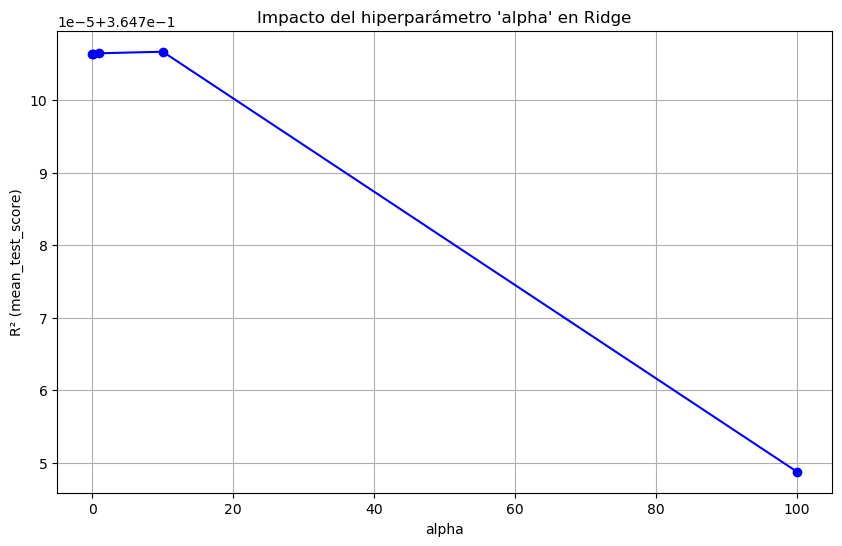

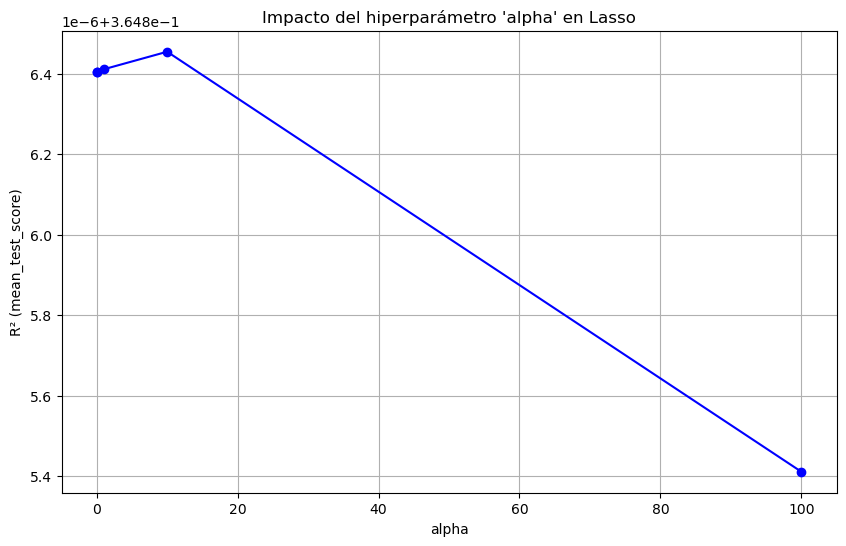

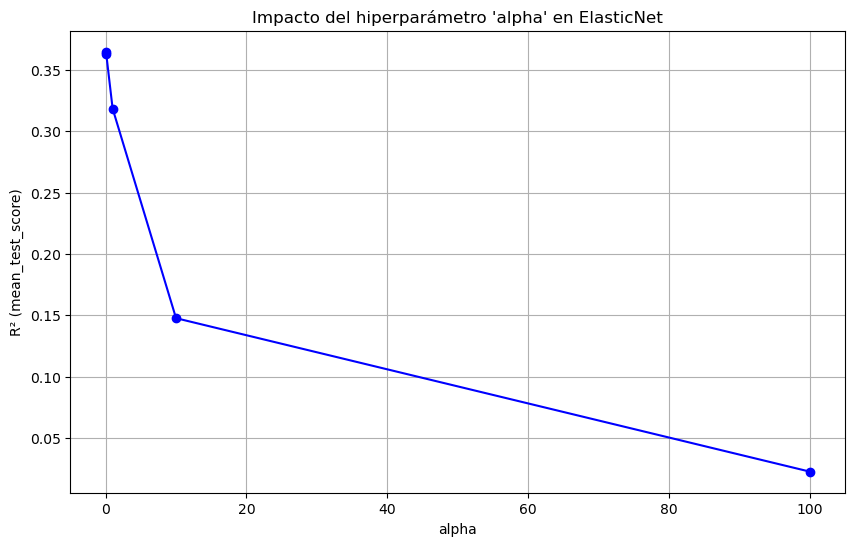

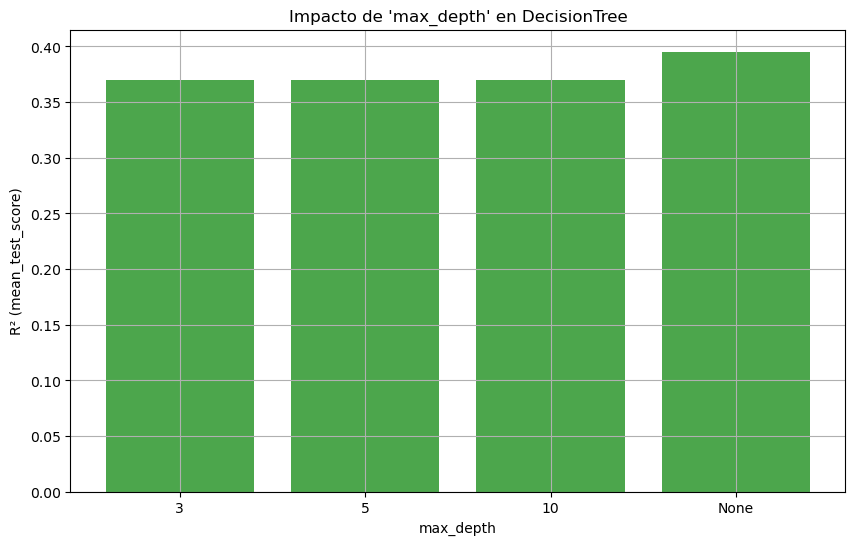

In [339]:
# Función para graficar resultados de GridSearchCV
def plot_hyperparameter_impact(grid_search, param_name, model_name):
    results = grid_search.cv_results_
    param_values = results['param_' + param_name]
    mean_scores = results['mean_test_score']
    
    plt.figure(figsize=(10, 6))
    plt.plot(param_values, mean_scores, marker='o', linestyle='-', color='blue')
    plt.title(f"Impacto del hiperparámetro '{param_name}' en {model_name}")
    plt.xlabel(param_name)
    plt.ylabel("R² (mean_test_score)")
    plt.grid(True)
    plt.show()

# Graficar para Ridge
plot_hyperparameter_impact(ridge, 'alpha', 'Ridge')

# Graficar para Lasso
plot_hyperparameter_impact(lasso, 'alpha', 'Lasso')

# Graficar para ElasticNet
plot_hyperparameter_impact(elastic_net, 'alpha', 'ElasticNet')

# Graficar para Árbol de Decisión (max_depth)
param_values = [str(v) for v in param_tree['max_depth']]
tree_mean_scores = tree.cv_results_['mean_test_score'][:len(param_values)]

plt.figure(figsize=(10, 6))
plt.bar(param_values, tree_mean_scores, color='green', alpha=0.7)
plt.title("Impacto de 'max_depth' en DecisionTree")
plt.xlabel("max_depth")
plt.ylabel("R² (mean_test_score)")
plt.grid(True)
plt.show()



#### <span style="color:purple">Análisis del impacto de los hiperparámetros en los modelos</span>

A continuación se explican los gráficos que muestran cómo varían las puntuaciones promedio de validación cruzada (R2) en función de los hiperparámetros ajustados para cada modelo. Estos gráficos permiten evaluar la sensibilidad de los modelos a los cambios en los hiperparámetros y seleccionar los valores óptimos.


1. **Impacto del hiperparámetro alpha en Ridge**
   
  - El gráfico muestra cómo el R2 promedio cambia a medida que se ajusta el valor de alpha en el modelo Ridge.
  - Se observa que un alpha pequeño (<10) logra el mejor desempeño, con un R2 cercano a 0.3648.
  - A medida que alpha aumenta, R2 disminuye indicando que penalizaciones muy fuertes perjudican el ajuste del modelo.
  - Un alpha de 10 ofrece el balance óptimo entre regularización y ajuste para este modelo.


2. **Impacto del hiperparámetro alpha en Lasso**

  - Similar al modelo Ridge, el mejor R2 (0.3648) se alcanza con un alpha de 10.
  - A medida que alpha aumenta el R2 disminuye, lo que sugiere que una regularización excesiva reduce la capacidad del modelo para capturar patrones relevantes.
  - El valor óptimo de alpha para Lasso es también 10, lo que garantiza un buen desempeño sin sobreajuste.
    

3. **Impacto del hiperparámetro alpha en ElasticNet**

  - En ElasticNet, el mejor R2 de 0.3648, se logra con un alpha muy pequeño (0.01).
  - A medida que alpha aumenta el R² disminuye, indicando que ElasticNet es más sensible a los valores altos de alpha en comparación con Ridge y Lasso.
  - ElasticNet es más efectivo con penalizaciones más débiles, lo que permite un mejor ajuste de los datos.
    

4. **Impacto del hiperparámetro max_depth en Árbol de regresión**

  - Este gráfico muestra cómo el R2 promedio varía en función de la profundidad máxima del árbol de decisión.
  - Se observa que el mejor desempeño se obtiene con una profundidad de 5, alcanzando un R² de 0.3953.
  - Las profundidades mayores no muestran mejoras significativas, lo que sugiere que un árbol más profundo no agrega mucho valor para este conjunto de datos.
  - Un *max_depth* de 5 es suficiente para capturar relaciones relevantes sin sobreajuste.

---

**Conclusión**

1. Los gráficos muestran cómo el ajuste de los hiperparámetros afecta el desempeño de los modelos.
2. Para los modelos lineales (Ridge, Lasso, ElasticNet), los valores pequeños de alpha de 10 o menos, ofrecen el mejor desempeño.
3. El árbol de decisión es mejor a una profundidad moderada (max_depth de 5).
4. Estos análisis ayudan a justificar la selección de hiperparámetros y aseguran que los modelos sean interpretables y efectivos.

## <span style="color:orange">Uso de métricas de evaluación</span>

- **Los pasos a seguir para desarrollar este punto son:**
 
1. **Predicción en el conjunto de prueba:** Utilizar los modelos ajustados en los pasos anteriores (Ridge, Lasso, ElasticNet y Árbol de regresoón) para realizar predicciones en el conjunto de prueba X_test.

2. **Cálculo de las métricas para cada modelo:**

- **MSE:** Promedio del cuadrado de los errores entre las predicciones y los valores reales.
- **MAE:** Promedio de las diferencias absolutas entre las predicciones y los valores reales.
- **R2:** Medida de la proporción de variabilidad explicada por el modelo.

3. **Comparación de los resultados:** Resumir las métricas en un DataFrame para comparar el rendimiento de los modelos y concluir cuál es el más efectivo.

In [342]:
# Crear un diccionario para almacenar las métricas
# Este diccionario servirá como estructura para guardar las métricas de evaluación (MSE, MAE, R²) para cada modelo.
resultados_metricas = {
    "Modelo": [],  # Lista para almacenar los nombres de los modelos.
    "MSE": [],     # Lista para almacenar los valores del Error Cuadrático Medio (MSE).
    "MAE": [],     # Lista para almacenar los valores del Error Absoluto Medio (MAE).
    "R²": []       # Lista para almacenar los valores del Coeficiente de Determinación (R²).
}

# Lista de modelos ajustados
# Contiene los modelos previamente entrenados con los mejores hiperparámetros encontrados.
modelos_ajustados = {
    "Ridge": ridge_best,          # Modelo Ridge ajustado con el mejor valor de alpha.
    "Lasso": lasso_best,          # Modelo Lasso ajustado con el mejor valor de alpha.
    "ElasticNet": elastic_net_best,  # Modelo ElasticNet ajustado con el mejor valor de alpha.
    "DecisionTree": tree_best     # Árbol de decisión ajustado con los mejores hiperparámetros.
}

# Calcular las métricas para cada modelo
# Este bucle iterará sobre los modelos ajustados, evaluándolos en el conjunto de prueba (X_test, y_test).
for nombre_modelo, modelo in modelos_ajustados.items():
    # Realizar predicciones en el conjunto de prueba
    # Se utiliza el método predict() del modelo para generar predicciones basadas en X_test.
    y_pred = modelo.predict(X_test)
    
    # Calcular las métricas de evaluación
    # 1. MSE (Error Cuadrático Medio): Indica el promedio de los errores al cuadrado. Penaliza errores grandes.
    mse = mean_squared_error(y_test, y_pred)
    # 2. MAE (Error Absoluto Medio): Mide el promedio de los errores absolutos. Más robusto frente a outliers.
    mae = mean_absolute_error(y_test, y_pred)
    # 3. R² (Coeficiente de Determinación): Indica qué proporción de la varianza en y_test es explicada por el modelo.
    r2 = r2_score(y_test, y_pred)
    
    # Guardar los resultados en el diccionario
    # Se añade el nombre del modelo y los valores calculados de MSE, MAE, y R² a las listas correspondientes.
    resultados_metricas["Modelo"].append(nombre_modelo)
    resultados_metricas["MSE"].append(mse)
    resultados_metricas["MAE"].append(mae)
    resultados_metricas["R²"].append(r2)

# Crear un DataFrame para los resultados
# Convierte el diccionario en un DataFrame para facilitar su visualización y análisis.
df_resultados_metricas = pd.DataFrame(resultados_metricas)

# Mostrar los resultados en la consola
# Imprime el DataFrame con las métricas calculadas para cada modelo.
print("Resultados de las métricas de evaluación para cada modelo:\n")
df_resultados_metricas


Resultados de las métricas de evaluación para cada modelo:



,Modelo,MSE,MAE,R²
0,Ridge,2.463130e+10,125790.071842,0.372009
1,Lasso,2.463182e+10,125787.007037,0.371995
2,ElasticNet,2.462733e+10,125816.955936,0.372110
3,DecisionTree,2.287624e+10,119755.753747,0.416755


#### <span style="color:purple">Explicación de los resultados</span>

1. **Error Cuadrático Medio (MSE)**

- MSE mide el promedio del cuadrado de las diferencias entre los valores predichos y los valores reales. *Valores más bajos indican un mejor desempeño*.
- El **Árbol de regresión** tiene el MSE más bajo (22.88B), lo que indica que es el modelo que comete los errores más pequeños en promedio.
- Los modelos lineales (Ridge, Lasso y ElasticNet) tienen MSE similares (24.63B), pero son mayores que los del árbol de rregresión.

2. **Error Absoluto Medio (MAE)**

- MAE mide el promedio de las diferencias absolutas entre los valores predichos y los valores reales. *Valores más bajos indican un mejor desempeño*.
- **Árbol de regresión** nuevamente tiene el MAE más bajo (119,755), indicando un mejor ajuste a los datos.
- Los modelos lineales presentan valores similares (125,790), mostrando una precisión menor en comparación con el árbol de decisión.

3. **Coeficiente de Determinación (R2)**
- R2 mide qué tan bien las predicciones explican la variabilidad de los datos. *Valores cercanos a 1 indican un modelo que explica mejor la variación*.
- **Árbol de regresión** tiene el mayor R2 (0.417), mostrando que captura mejor las relaciones complejas en los datos.
- Los modelos lineales tienen un R² similar (0.372), lo que indica que explican menos de la variabilidad total en comparación con el árbol de decisión.

---

**Conclusión**
1. El **árbol de regresión** supera a los modelos lineales en todas las métricas (MSE, MAE y R²), mostrando ser el modelo más efectivo para este conjunto de datos.
2. Los modelos lineales (**Ridge**, **Lasso**, **ElasticNet**) tienen un desempeño casi idéntico, lo que sugiere que las relaciones lineales son similares entre ellos, pero no logran capturar por completo la complejidad de los datos.
3. Para capturar relaciones no lineales y complejas, **árbol de regresión** es la opción más adecuada en este caso.
